In [5]:
import numpy as np
import pandas as pd
import jax.numpy as jnp

from pathlib import Path
import matplotlib.pyplot as plt

import pdb

from elder_care.simulate import (
    get_share_by_age, get_share_by_age_bin,
    get_mean_by_age_bin_for_lagged_choice,
    get_mean_by_age_bin_for_lagged_choice,
    get_share_by_type_by_age_bin,
    get_share_by_type,
    get_share_care_type_by_parental_health,
    get_transition
)

/tmp/ipykernel_21726/3449565675.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
from dcegm.pre_processing.model_functions import process_model_functions
from dcegm.pre_processing.params import process_params
from dcegm.pre_processing.state_space import create_state_space_and_choice_objects
from dcegm.pre_processing.state_space import create_state_space, create_state_choice_space
from dcegm.pre_processing.state_space import process_endog_state_specifications
from dcegm.pre_processing.state_space import process_exog_model_specifications
from dcegm.pre_processing.state_space import inspect_state_space
from dcegm.solve import get_solve_function

from dcegm.simulation.simulate import simulate_all_periods
from dcegm.numerical_integration import quadrature_legendre

In [7]:
BLD = "../../../bld"

In [8]:
MIN_AGE = 51
MAX_AGE = 80

PARENT_MIN_AGE = 68
PARENT_MAX_AGE = 98

RETIREMENT_AGE = 62

GOOD_HEALTH = 0
MEDIUM_HEALTH = 1
BAD_HEALTH = 2

In [9]:
def is_not_working(lagged_choice):
    return jnp.any(lagged_choice == NO_WORK)


def is_part_time(lagged_choice):
    return jnp.any(lagged_choice == PART_TIME)


def is_full_time(lagged_choice):
    return jnp.any(lagged_choice == FULL_TIME)


def is_informal_care(lagged_choice):
    # intensive only here
    return jnp.any(lagged_choice == INFORMAL_CARE)


def is_no_informal_care(lagged_choice):
    # intensive only here
    return jnp.all(lagged_choice != INFORMAL_CARE)


def is_formal_care(lagged_choice):
    return jnp.any(lagged_choice == FORMAL_CARE)


def is_no_formal_care(lagged_choice):
    return jnp.all(lagged_choice != FORMAL_CARE)

In [10]:
def plot_working_status(data, working_status):
    # Extract ages and corresponding shares
    ages = [int(idx.split('_')[-1]) for idx in data.index if idx.startswith(f'{working_status}_age_')]
    shares = data.loc[data.index.str.startswith(f'{working_status}_age_')].values.ravel()

    # Create a DataFrame for easier plotting
    df = pd.DataFrame({'Age': ages, f'Share of {working_status.capitalize()}': shares})

    # Sort the DataFrame by Age for better visualization
    df = df.sort_values(by='Age')

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df['Age'], df[f'Share of {working_status.capitalize()}'], marker='o', linestyle='-')
    plt.title(f'Share of {working_status.capitalize()} People by Age')
    plt.xlabel('Age')
    plt.ylabel(f'Share of {working_status.capitalize()}')
    plt.grid(True)
    plt.show()

In [7]:

def create_simulation_array(sim_dict, options, params, n_agents):
    n_periods, n_agents, n_choices = sim_dict["taste_shocks"].shape

    # Convert the dictionary to arrays
    agent = jnp.tile(jnp.arange(n_agents), n_periods)
    period = sim_dict["period"].ravel()
    savings = sim_dict["savings"].ravel()
    consumption = sim_dict["consumption"].ravel()
    lagged_choice = sim_dict["lagged_choice"].ravel()
    choice = sim_dict["choice"].ravel()
    income_shock = sim_dict["income_shock"].ravel()

    # Compute additional variables
    wealth = savings + consumption
    #savings_rate = savings / wealth
    savings_rate = jnp.where(wealth > 0, jnp.divide(savings, wealth), 0)
    period_indices = jnp.tile(jnp.arange(n_periods)[:, None], (1, n_agents)).ravel()
    age = period_indices + options["model_params"]["min_age"]

    # Adjusting the logic for PART_TIME and FULL_TIME checks
    is_part_time = jnp.isin(lagged_choice, PART_TIME)
    is_full_time = jnp.isin(lagged_choice, FULL_TIME)

    log_wage = (
        params["wage_constant"]
        + params["wage_age"] * age
        + params["wage_age_squared"] * age ** 2
        + params["wage_part_time"] * is_part_time
        + params["wage_not_working"] * is_full_time
    )

    wage = jnp.exp(log_wage + income_shock)

    # Adapt _assign_working_hours to work with vectorized operations in JAX
    # Example stub for _assign_working_hours function
    # Vectorize the _assign_working_hours function if it's not already suitable for vector operations
    working_hours = jax.vmap(_assign_working_hours_vectorized)(lagged_choice)

    income = working_hours * wage

    result= jnp.column_stack((agent, period, lagged_choice, wealth, savings_rate, wage, working_hours, income, choice))


    # Return the results as a dictionary or a structured array
    #result = sim_dict | {
    #    "wealth": wealth,
    #    "age": age,
    #    "log_wage": log_wage,
    #    "wage": wage,
    #    "working_hours": working_hours,
    #    "income": income
    #}
    return result


def _assign_working_hours_vectorized(choices):
    # Create boolean masks for each condition
    no_work_mask = jnp.isin(choices, NO_WORK)
    part_time_mask = jnp.isin(choices, PART_TIME)
    full_time_mask = jnp.isin(choices, FULL_TIME)

    # Use where to vectorize the conditional assignment of hours
    hours = jnp.where(no_work_mask, 0,
                      jnp.where(part_time_mask, 20,
                                jnp.where(full_time_mask, 40, jnp.nan)))

    return hours


In [8]:
def simulate_moments(arr, idx):
    """Df has multiindex ["period", "agent"] necessary?

    column_indices = {col: idx for idx, col in enumerate(sim.columns)}
    idx = column_indices.copy()
    arr = jnp.asarray(sim)

    """


    # share working by age
    share_not_working_by_age = get_share_by_age(
        arr,
        ind=idx,
        lagged_choice=NO_WORK,
    )  # 15
    share_working_part_time_by_age = get_share_by_age(
        arr,
        ind=idx,
        lagged_choice=PART_TIME,
    )  # 15
    share_working_full_time_by_age = get_share_by_age(
        arr,
        ind=idx,
        lagged_choice=FULL_TIME,
    )  # 15
    # do timeit of jnp.array versus jnp.asarray?

    share_informal_care_by_age_bin = get_share_by_type_by_age_bin(
        arr,
        ind=idx,
        care_type=ALL,
        lagged_choice=INFORMAL_CARE,
    )

    # yearly net income
    # Caution: Some bug here!! Zero income, althouh working (full-time),
    # so people have to live off of their initial wealth
    #income_part_time_by_age_bin = get_mean_by_age_bin_for_lagged_choice(
    #    arr,
    #    ind=idx,
    #    var="income",
    #    lagged_choice=PART_TIME,
    #)
    #income_full_time_by_age_bin = get_mean_by_age_bin_for_lagged_choice(
    #    arr,
    #    ind=idx,
    #    var="income",
    #    lagged_choice=FULL_TIME,
    #)

    # savings rate
    #savings_rate_no_informal_care_by_age_bin = get_savings_rate_by_age_bin(
    #    arr,
    #   ind=idx,
    #    care_type=NO_INFORMAL_CARE,
    #)

    #savings_rate_informal_care_by_age_bin = get_savings_rate_by_age_bin(
    #    arr,
    #    ind=idx,
    #    care_type=INFORMAL_CARE,
    #)

    # share working by caregiving type (and age bin) --> to be checked

    #
    share_not_working_no_informal_care = get_share_by_type(
        arr,
        ind=idx,
        lagged_choice=NO_WORK,
        care_type=NO_INFORMAL_CARE,
    )
    share_part_time_no_informal_care = get_share_by_type(
        arr,
        ind=idx,
        lagged_choice=PART_TIME,
        care_type=NO_INFORMAL_CARE,
    )
    share_full_time_no_informal_care = get_share_by_type(
        arr,
        ind=idx,
        lagged_choice=FULL_TIME,
        care_type=NO_INFORMAL_CARE,
    )

    share_not_working_informal_care = get_share_by_type(
        arr,
        ind=idx,
        lagged_choice=NO_WORK,
        care_type=INFORMAL_CARE,
    )
    share_part_time_informal_care = get_share_by_type(
        arr,
        ind=idx,
        lagged_choice=PART_TIME,
        care_type=INFORMAL_CARE,
    )
    share_full_time_informal_care = get_share_by_type(
        arr,
        ind=idx,
        lagged_choice=FULL_TIME,
        care_type=INFORMAL_CARE,
    )

    # work transitions
    no_work_to_no_work = get_transition(
        arr,
        ind=idx,
        lagged_choice=NO_WORK,
        current_choice=NO_WORK,
    )
    no_work_to_part_time = get_transition(
        arr,
        ind=idx,
        lagged_choice=NO_WORK,
        current_choice=PART_TIME,
    )
    no_work_to_full_time = get_transition(
        arr,
        ind=idx,
        lagged_choice=NO_WORK,
        current_choice=FULL_TIME,
    )

    part_time_to_no_work = get_transition(
        arr,
        ind=idx,
        lagged_choice=PART_TIME,
        current_choice=NO_WORK,
    )
    part_time_to_part_time = get_transition(
        arr,
        ind=idx,
        lagged_choice=PART_TIME,
        current_choice=PART_TIME,
    )
    part_time_to_full_time = get_transition(
        arr,
        ind=idx,
        lagged_choice=PART_TIME,
        current_choice=FULL_TIME,
    )

    full_time_to_no_work = get_transition(
        arr,
        ind=idx,
        lagged_choice=FULL_TIME,
        current_choice=NO_WORK,
    )
    full_time_to_part_time = get_transition(
        arr,
        ind=idx,
        lagged_choice=FULL_TIME,
        current_choice=PART_TIME,
    )
    full_time_to_full_time = get_transition(
        arr,
        ind=idx,
        lagged_choice=FULL_TIME,
        current_choice=FULL_TIME,
    )

    # caregiving transitions
    no_informal_care_to_no_informal_care = get_transition(
        arr,
        ind=idx,
        lagged_choice=NO_INFORMAL_CARE,
        current_choice=NO_INFORMAL_CARE,
    )
    no_informal_care_to_informal_care = get_transition(
        arr,
        ind=idx,
        lagged_choice=NO_INFORMAL_CARE,
        current_choice=INFORMAL_CARE,
    )

    informal_care_to_no_informal_care = get_transition(
        arr,
        ind=idx,
        lagged_choice=INFORMAL_CARE,
        current_choice=NO_INFORMAL_CARE,
    )
    informal_care_to_informal_care = get_transition(
        arr,
        ind=idx,
        lagged_choice=INFORMAL_CARE,
        current_choice=INFORMAL_CARE,
    )

    no_informal_care_to_no_formal_care = get_transition(
        arr,
        ind=idx,
        lagged_choice=NO_INFORMAL_CARE,
        current_choice=NO_FORMAL_CARE,
    )
    no_informal_care_to_formal_care = get_transition(
        arr,
        ind=idx,
        lagged_choice=NO_INFORMAL_CARE,
        current_choice=FORMAL_CARE,
    )

    informal_care_to_no_formal_care = get_transition(
        arr,
        ind=idx,
        lagged_choice=INFORMAL_CARE,
        current_choice=NO_FORMAL_CARE,
    )
    informal_care_to_formal_care = get_transition(
        arr,
        ind=idx,
        lagged_choice=INFORMAL_CARE,
        current_choice=FORMAL_CARE,
    )

    no_formal_care_to_no_informal_care = get_transition(
        arr,
        ind=idx,
        lagged_choice=NO_FORMAL_CARE,
        current_choice=NO_INFORMAL_CARE,
    )
    no_formal_care_to_informal_care = get_transition(
        arr,
        ind=idx,
        lagged_choice=NO_FORMAL_CARE,
        current_choice=INFORMAL_CARE,
    )

    formal_care_to_no_informal_care = get_transition(
        arr,
        ind=idx,
        lagged_choice=FORMAL_CARE,
        current_choice=NO_INFORMAL_CARE,
    )
    formal_care_to_informal_care = get_transition(
        arr,
        ind=idx,
        lagged_choice=FORMAL_CARE,
        current_choice=INFORMAL_CARE,
    )

    no_formal_care_to_no_formal_care = get_transition(
        arr,
        ind=idx,
        lagged_choice=NO_FORMAL_CARE,
        current_choice=NO_FORMAL_CARE,
    )
    no_formal_care_to_formal_care = get_transition(
        arr,
        ind=idx,
        lagged_choice=NO_FORMAL_CARE,
        current_choice=FORMAL_CARE,
    )

    formal_care_to_no_formal_care = get_transition(
        arr,
        ind=idx,
        lagged_choice=FORMAL_CARE,
        current_choice=NO_FORMAL_CARE,
    )
    formal_care_to_formal_care = get_transition(
        arr,
        ind=idx,
        lagged_choice=FORMAL_CARE,
        current_choice=FORMAL_CARE,
    )

    return jnp.asarray(
        share_not_working_by_age
        + share_working_part_time_by_age
        + share_working_full_time_by_age
        +
        #
        share_informal_care_by_age_bin
        #
        #income_part_time_by_age_bin
        #+ income_full_time_by_age_bin
        #+ savings_rate_no_informal_care_by_age_bin
        #+ savings_rate_informal_care_by_age_bin
        #
        +
        [share_not_working_no_informal_care]
        + [share_part_time_no_informal_care]
        + [share_full_time_no_informal_care]
        + [share_not_working_informal_care]
        + [share_part_time_informal_care]
        + [share_full_time_informal_care]
        +
        #
        no_work_to_no_work
        + no_work_to_part_time
        + no_work_to_full_time
        + part_time_to_no_work
        + part_time_to_part_time
        + part_time_to_full_time
        + full_time_to_no_work
        + full_time_to_part_time
        + full_time_to_full_time
        +
        # caregiving transitions
        no_informal_care_to_no_informal_care
        + no_informal_care_to_informal_care
        + informal_care_to_no_informal_care
        + informal_care_to_informal_care
        + no_informal_care_to_no_formal_care
        + no_informal_care_to_formal_care
        + informal_care_to_no_formal_care
        + informal_care_to_formal_care
        +
        #
        no_formal_care_to_no_informal_care
        + no_formal_care_to_informal_care
        + formal_care_to_no_informal_care
        + formal_care_to_informal_care
        + no_formal_care_to_no_formal_care
        + no_formal_care_to_formal_care
        + formal_care_to_no_formal_care
        + formal_care_to_formal_care,
    )

In [9]:
ALL = jnp.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

NO_WORK = jnp.array([0, 1, 2, 3])
PART_TIME = jnp.array([4, 5, 6, 7])
FULL_TIME = jnp.array([8, 9, 10, 11])
WORK = jnp.concatenate([PART_TIME, FULL_TIME])

NO_CARE = jnp.array([0, 4, 8])
FORMAL_CARE = jnp.array([1, 3, 5, 7, 9, 11])
INFORMAL_CARE = jnp.array([2, 3, 6, 7, 10, 11])
CARE = jnp.concatenate([FORMAL_CARE, INFORMAL_CARE])

COMBINATION_CARE = jnp.array([3, 7, 11])

# For NO_INFORMAL_CARE and NO_FORMAL_CARE, we need to perform set operations before converting to JAX arrays.
# This is because JAX doesn't support direct set operations.
# Convert the results of set operations to lists, then to JAX arrays.
NO_INFORMAL_CARE = jnp.array(list(set(ALL.tolist()) - set(INFORMAL_CARE.tolist())))
NO_FORMAL_CARE = jnp.array(list(set(ALL.tolist()) - set(FORMAL_CARE.tolist())))

In [10]:
TOTAL_WEEKLY_HOURS = 80
WEEKLY_HOURS_PART_TIME = 20
WEEKLY_HOURS_FULL_TIME = 40
WEEKLY_INTENSIVE_INFORMAL_HOURS = 14  # (21 + 7) / 2

N_MONTHS = 12
N_WEEKS = 4.33

PART_TIME_HOURS = 20 * N_WEEKS * N_MONTHS
FULL_TIME_HOURS = 40 * N_WEEKS * N_MONTHS

In [11]:
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
from itertools import product
from functools import partial
import time

import seaborn as sns
import matplotlib.pyplot as plt

from typing import Dict
from typing import Tuple

from elder_care.model import (
    prob_part_time_offer,
    prob_full_time_offer,
    prob_exog_care_demand_basic,
    prob_survival_mother,
    prob_survival_father,
    #exog_health_transition_mother,
    #exog_health_transition_father,
)

from elder_care.model import budget_constraint, calc_stochastic_wage
from elder_care.model import utility_func, marginal_utility, inverse_marginal_utility

from elder_care.model import get_state_specific_feasible_choice_set, update_endog_state

from elder_care.model import (
    utility_final_consume_all,
    marginal_utility_final_consume_all,
)
from elder_care.simulate import draw_initial_states, simulate_moments, create_simulation_df

In [12]:
model_params = {
    "quadrature_points_stochastic": 5,
    "n_choices": 12,
    "min_age": MIN_AGE,
    "max_age": MAX_AGE,
    "mother_min_age": PARENT_MIN_AGE,
    "father_min_age": PARENT_MIN_AGE,
    # annual
    "consumption_floor": 400 * 12,
    "unemployment_benefits": 500 * 12,
    "informal_care_benefits": 444.0466 * 12,  # 0.4239 * 316 + 0.2793 * 545 + 728 *0.1405 + 901 * 0.0617
    "formal_care_costs": 118.10658099999999 * 12,  # >>> 79.31 * 0.0944 + 0.4239 * 70.77 + 0.2793 * 176.16 + 224.26 *0.1401
    "interest_rate": 0.04,  # Adda et al (2017)
    # ===================
    # EXOGENOUS PROCESSES
    # ===================
    # survival probability
    "survival_probability_mother_constant": 17.01934835131644,
    "survival_probability_mother_age": -0.21245937682111807,
    "survival_probability_mother_age_squared": 0.00047537366767865137,
    "survival_probability_father_constant": 11.561515476144223,
    "survival_probability_father_age": -0.11058331994203506,
    "survival_probability_father_age_squared": -1.0998977981246952e-05,
    # health
    "mother_medium_health": {
        "medium_health_age": 0.0304,
        "medium_health_age_squared": -1.31e-05,
        "medium_health_lagged_good_health": -1.155,
        "medium_health_lagged_medium_health": 0.736,
        "medium_health_lagged_bad_health": 1.434,
        "medium_health_constant": -1.550,
    },
    "mother_bad_health": {
        "bad_health_age": 0.196,
        "bad_health_age_squared": -0.000885,
        "bad_health_lagged_good_health": -2.558,
        "bad_health_lagged_medium_health": -0.109,
        "bad_health_lagged_bad_health": 2.663,
        "bad_health_constant": -9.220,
    },
    "father_medium_health": {
        "medium_health_age": 0.176,
        "medium_health_age_squared": -0.000968,
        "medium_health_lagged_good_health": -1.047,
        "medium_health_lagged_medium_health": 1.016,
        "medium_health_lagged_bad_health": 1.743,
        "medium_health_constant": -7.374,
    },
    "father_bad_health": {
        "bad_health_age": 0.260,
        "bad_health_age_squared": -0.00134,
        "bad_health_lagged_good_health": -2.472,
        "bad_health_lagged_medium_health": 0.115,
        "bad_health_lagged_bad_health": 3.067,
        "bad_health_constant": -11.89,
    },
    # TODO: care demand
    # "exog_care_single_mother_constant": 27.894895,
    #"exog_care_single_mother_age": -0.815882,
    #"exog_care_single_mother_age_squared": 0.005773,
    #"exog_care_single_mother_medium_health": 0.652438,
    #"exog_care_single_mother_bad_health": 0.924265,
    #
    #"exog_care_single_father_constant": 17.833432,
    #"exog_care_single_father_age": -0.580729,
    #"exog_care_single_father_age_squared": 0.004380,
    #"exog_care_single_father_medium_health": 0.594160,
    #"exog_care_single_father_bad_health": 0.967142,
    #
    #"exog_care_couple_constant": 32.519891,
    #"exog_care_couple_mother_age": -0.916759,
    #"exog_care_couple_mother_age_squared": 0.006190,
    #"exog_care_couple_father_age": -0.046230,
    #"exog_care_couple_father_age_squared": 0.000583,
    #"exog_care_couple_mother_medium_health": 0.449386,
    #"exog_care_couple_mother_bad_health": 0.719621,
    #"exog_care_couple_father_medium_health": 0.360010,
    #"exog_care_couple_father_bad_health": 0.800824,
    #
    # TODO: care demand
    "exog_care_single_mother_constant": 22.322551,
    "exog_care_single_mother_age": -0.661611,
    "exog_care_single_mother_age_squared": 0.004840,
    #
    "exog_care_single_father_constant": 16.950484,
    "exog_care_single_father_age": -0.541042,
    "exog_care_single_father_age_squared": 0.004136,
    #
    "exog_care_couple_constant": 22.518664,
    "exog_care_couple_mother_age": -0.622648,
    "exog_care_couple_mother_age_squared": 0.004346,
    "exog_care_couple_father_age": -0.068347,
    "exog_care_couple_father_age_squared": 0.000769,
    #
}

In [13]:
options = {
    "state_space": {
        "n_periods": 20,
        "n_choices": 12,
        "choices": np.arange(12),
        "endogenous_states": {
            "married": np.arange(2),
            "has_sibling": np.arange(2),
        },
        "exogenous_processes": {
            "part_time_offer": {
                "states": np.arange(2),
                "transition": prob_part_time_offer,
            },
            "full_time_offer": {
                "states": np.arange(2),
                "transition": prob_full_time_offer,
            },
            "care_demand": {
                "states": np.arange(2),
                "transition": prob_exog_care_demand_basic,
            },
            "mother_alive": {
               "states": np.arange(2),
               "transition": prob_survival_mother,
            },
            "father_alive": {
                "states": np.arange(2),
               "transition": prob_survival_father,
            },
            #"mother_health": {
            #    "states": np.arange(3),
            #    "transition": exog_health_transition_mother,
            #},
            #"father_health": {
            #    "states": np.arange(3),
            #    "transition": exog_health_transition_father,
            #},
        },
    },
}

In [14]:
params_test = {
    # job offer
    "part_time_constant": -0.8,
    "part_time_not_working_last_period": -1.576,
    "part_time_working_full_time_last_period": 0.3,
    "part_time_above_retirement_age": 0.6,
    "full_time_constant": -0.3,
    "full_time_not_working_last_period": -2,
    "full_time_working_part_time_last_period": 0.5,
    "full_time_above_retirement_age": -1.75,
    # wage
    "wage_constant": 0.32,
    "wage_age": 0.05,
    "wage_age_squared": -0.0006,
    "wage_part_time": -0.1,
    "wage_not_working": -0.3,
    # utility
    "rho": 0.5,  # risk aversion
    "utility_leisure_constant": 3,
    "utility_leisure_age": 0.36,
    "disutility_part_time": -0.5,
    "disutility_full_time": -1,
    "utility_informal_care": 2,
    "utility_formal_care": 2,
    "utility_informal_and_formal_care": -1,
    ### fixed
    "beta": 0.95,  # 0.98
    "lambda": 1e-16,  # Taste shock scale/variance. Almost equal zero = no taste shocks
    "sigma": 1,  # Income shock scale/variance.
}

In [15]:
options["model_params"] = model_params

In [20]:
utility_functions = {
    "utility": utility_func,
    "marginal_utility": marginal_utility,
    "inverse_marginal_utility": inverse_marginal_utility,

}

utility_functions_final_period = {
        "utility": utility_final_consume_all,
        "marginal_utility": marginal_utility_final_consume_all,
    }

state_space_functions = {
    #"update_endog_state_by_state_and_choice": update_endog_state,
    "get_next_period_state": update_endog_state,
    "get_state_specific_choice_set": get_state_specific_feasible_choice_set,
}

In [21]:
def logspace(start, stop, n_points):
    start_lin = jnp.log(start)
    stop_lin = jnp.log(stop)
    return jnp.logspace(start_lin, stop_lin, n_points, base=2.718281828459045)

start_lin = 0
stop_lin = 1_000_000
n_points = 1_000
exog_savings_grid_one = jnp.arange(start=0,stop=100_000,step=200)
exog_savings_grid_two = jnp.arange(start=100_000,stop=1_000_000,step=10_000)
exog_savings_grid_three = jnp.arange(start=1_000_000,stop=11_000_000,step=1_000_000)

In [22]:
exog_savings_grid = jnp.concatenate([exog_savings_grid_one, exog_savings_grid_two, exog_savings_grid_three])

In [23]:
(
    model_funcs,
    compute_upper_envelope,
    get_state_specific_choice_set,
    update_endog_state_by_state_and_choice,
) = process_model_functions(
    options,
    state_space_functions=state_space_functions,
    utility_functions=utility_functions,
    utility_functions_final_period=utility_functions_final_period,
    budget_constraint=budget_constraint,
    )

In [25]:
solve_func = get_solve_function(
    options=options,
    exog_savings_grid=exog_savings_grid,
    utility_functions=utility_functions,
    utility_functions_final_period=utility_functions_final_period,
    budget_constraint=budget_constraint,
    state_space_functions=state_space_functions,
)

In [26]:
params = {'part_time_constant': 1.9039744394564848,
 'part_time_not_working_last_period': 0.8140032771945565,
 'part_time_working_full_time_last_period': 1.9986604717837122,
 'part_time_above_retirement_age': -0.10967500332770141,
 'full_time_constant': 2.424830416485194,
 'full_time_not_working_last_period': -2.549310086740609,
 'full_time_working_part_time_last_period': 3.6164929716663443,
 'full_time_above_retirement_age': -3.2105565169713763,
 'wage_constant': 2.6858232962606876,
 'wage_age': 1.074908693723371,
 'wage_age_squared': -3.3287973353563896,
 'wage_part_time': 0.4729857370437544,
 'wage_not_working': 1.272419411564533,
 'utility_leisure_constant': -4.435797729688349,
 'utility_leisure_age': -0.14202541204013341,
 'disutility_part_time': 0.0,
 'disutility_full_time': -2.576739660448464,
 'utility_informal_care': 1.2149265332064965,
 'utility_formal_care': 0.7843696831762427,
 'utility_informal_and_formal_care': -0.7145974649111337,
 'rho': 1.95,
 'beta': 0.95,
 'lambda': 1e-16,
 'sigma': 1.0,
 'interest_rate': 0.04}

In [27]:
value, policy_left, policy_right, endog_grid = solve_func(params)

In [28]:
seed = 2024
n_choices = 12
n_agents = 10_000

In [65]:
path = f"{BLD}/moments/initial_wealth_at_age_50.csv"
initial_wealth_empirical = jnp.asarray(pd.read_csv(path)).ravel()

In [66]:
path = f"{BLD}/moments/initial_discrete_conditions_at_age_50.csv"
initial_conditions = pd.read_csv(path, index_col=0)

In [67]:
initial_resources, initial_states = draw_initial_states(
    initial_conditions, initial_wealth_empirical, n_agents, seed=seed
)

In [68]:
initial_resources

Array([ 514310.3 ,  207911.19,  188545.7 , ...,   60300.  ,  231650.58,
       3810460.8 ], dtype=float32)

In [69]:
initial_states["period"] = initial_states["period"].astype(np.int32)

In [70]:
initial_states["period"]

Array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [72]:
for key, value in initial_states.items():
    initial_states[key] = value.astype(np.int32)

In [73]:
initial_states

{'period': Array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'lagged_choice': Array([4, 0, 0, ..., 4, 0, 0], dtype=int32),
 'married': Array([1, 0, 1, ..., 1, 0, 1], dtype=int32),
 'has_sibling': Array([0, 0, 1, ..., 1, 1, 0], dtype=int32),
 'part_time_offer': Array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
 'full_time_offer': Array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
 'care_demand': Array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'mother_alive': Array([1, 1, 1, ..., 0, 1, 0], dtype=int32),
 'father_alive': Array([0, 0, 0, ..., 0, 0, 0], dtype=int32)}

In [74]:
MIN_AGE = 51
MAX_AGE = 65

AGE_50 = 50 - MIN_AGE
AGE_53 = 53 - MIN_AGE
AGE_56 = 56 - MIN_AGE
AGE_59 = 59 - MIN_AGE
AGE_62 = 62 - MIN_AGE

AGE_55 = 55 - MIN_AGE
AGE_60 = 60 - MIN_AGE
AGE_65 = 65 - MIN_AGE


AGE_BINS = [(AGE_50, AGE_55), (AGE_55, AGE_60), (AGE_60, AGE_65)]

In [75]:
n_periods = options["state_space"]["n_periods"]

# ToDo: Make interface with several draw possibilities.
# ToDo: Some day make user supplied draw function.
income_shock_draws_unscaled, income_shock_weights = quadrature_legendre(
    options["model_params"]["quadrature_points_stochastic"]
)

(
model_funcs,
        compute_upper_envelope,
        get_state_specific_choice_set,
        update_endog_state_by_state_and_choice,
    ) = process_model_functions(
        options,
        state_space_functions=state_space_functions,
        utility_functions=utility_functions,
        utility_functions_final_period=utility_functions_final_period,
        budget_constraint=budget_constraint,
)

(
period_specific_state_objects,
        state_space,
        state_space_names,
        map_state_choice_to_index,
        exog_state_space,
        exog_state_names,
    ) = create_state_space_and_choice_objects(
        options=options,
        get_state_specific_choice_set=get_state_specific_choice_set,
        get_next_period_state=update_endog_state_by_state_and_choice,
    )

In [76]:
def create_exog_mapping(exog_state_space, exog_names):
    def exog_mapping(exog_proc_state):
        # Caution: JAX does not throw an error if the exog_proc_state is out of bounds
        # If the index is out of bounds, the last element of the array is returned.
        exog_state = jnp.take(exog_state_space, exog_proc_state, axis=0)
        exog_state_dict = {
            key: jnp.take(exog_state, i) for i, key in enumerate(exog_names)
        }
        return exog_state_dict

    return exog_mapping

In [84]:
exog_state_space = exog_state_space.astype(np.int32)

In [85]:
exog_state_space

array([[0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 1, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0],
       [1, 0, 0, 1, 0],
       [1, 1, 0, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 1, 1, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 1, 0, 0, 1],
       [0, 0, 1, 0, 1],
       [0, 1, 1, 0, 1],
       [1, 0, 1, 0, 1],
       [1, 1, 1, 0, 1],
       [0, 0, 0, 1, 1],
       [0, 1, 0, 1, 1],
       [1, 0, 0, 1, 1],
       [1, 1, 0, 1, 1],
       [0, 0, 1, 1, 1],
       [0, 1, 1, 1, 1],
       [1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=int32)

In [77]:
exog_mapping = create_exog_mapping(exog_state_space, exog_state_names)

In [78]:
exog_state_names

['part_time_offer',
 'full_time_offer',
 'care_demand',
 'mother_alive',
 'father_alive']

In [79]:
exog_mapping

<function __main__.create_exog_mapping.<locals>.exog_mapping(exog_proc_state)>

In [ ]:
idx = {
    "agent": 0,
    "period": 1,
    "lagged_choice": 2,
    "wealth": 3,
    "savings_rate": 4,
    "wage": 5,
    "working_hours": 6,
    "income": 7,
    "choice": 8,
}

In [92]:
result = simulate_all_periods(
        states_initial=initial_states,
        resources_initial=initial_resources,
        n_periods=options["state_space"]["n_periods"],
        params=params_test,
        #
        state_space_names=state_space_names,
        seed=seed,
        #
        endog_grid_solved=endog_grid,
        value_solved=value,
        policy_left_solved=policy_left,
        policy_right_solved=policy_right,
        #
        map_state_choice_to_index=jnp.array(map_state_choice_to_index),
        choice_range=jnp.arange(map_state_choice_to_index.shape[-1], dtype=jnp.int16),
        compute_exog_transition_vec=model_funcs["compute_exog_transition_vec"],
        compute_utility=model_funcs["compute_utility"],
        compute_beginning_of_period_resources=model_funcs[
            "compute_beginning_of_period_resources"
        ],
        exog_state_mapping=exog_mapping,
        get_next_period_state=update_endog_state_by_state_and_choice,
        compute_utility_final_period=model_funcs["compute_utility_final"],
)

IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.

In [ ]:
simulated_arr = create_simulation_array(result, options=options, params=params_test, n_agents=n_agents)

In [12]:
sim_arr = np.array(
    [
        0.2744,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.3547,
        1.0,
        0.7791,
        0.8083,
        0.7991,
        0.8258,
        0.8741,
        0.9084,
        0.9256,
        0.9331,
        0.9412,
        0.9451,
        0.944,
        0.9455,
        0.9561,
        0.3709,
        0.0,
        0.2209,
        0.1917,
        0.2009,
        0.1742,
        0.1259,
        0.0916,
        0.0744,
        0.0669,
        0.0588,
        0.0549,
        0.056,
        0.0545,
        0.0439,
        0.15166,
        0.11896,
        0.06044,
        0.01512888,
        0.95311373,
        0.03175741,
        0.0,
        0.1575302,
        0.8424698,
        0.0,
        1.0,
        0.0,
        0.0,
        0.92796564,
        0.07203436,
        0.0,
        0.7583796,
        0.24162044,
        0.9244493,
        0.07555065,
        0.73573154,
        0.26426846,
        0.59156996,
        0.40843004,
        0.6409128,
        0.35908726,
        0.9006334,
        0.09936661,
        0.9173928,
        0.08260724,
        0.62864995,
        0.37135005,
        0.54142445,
        0.45857555,
    ]
)

In [13]:
empirical_moments = pd.read_csv("../../../bld/moments/empirical_moments.csv", index_col=0)
data = pd.read_csv("../../../bld/moments/empirical_moments.csv", index_col=0)

In [14]:
empirical_moments

,0
not_working_age_51,0.281756
not_working_age_52,0.289694
not_working_age_53,0.298129
not_working_age_54,0.318157
not_working_age_55,0.322436
...,...
home_care_to_informal_care,0.175128
no_home_care_to_no_home_care,0.879430
no_home_care_to_home_care,0.120570
home_care_to_no_home_care,0.328753


In [17]:
idx_moments = dict(enumerate(empirical_moments.index, start=0))
idx_moments

{0: 'not_working_age_51',
 1: 'not_working_age_52',
 2: 'not_working_age_53',
 3: 'not_working_age_54',
 4: 'not_working_age_55',
 5: 'not_working_age_56',
 6: 'not_working_age_57',
 7: 'not_working_age_58',
 8: 'not_working_age_59',
 9: 'not_working_age_60',
 10: 'not_working_age_61',
 11: 'not_working_age_62',
 12: 'not_working_age_63',
 13: 'not_working_age_64',
 14: 'not_working_age_65',
 15: 'part_time_age_51',
 16: 'part_time_age_52',
 17: 'part_time_age_53',
 18: 'part_time_age_54',
 19: 'part_time_age_55',
 20: 'part_time_age_56',
 21: 'part_time_age_57',
 22: 'part_time_age_58',
 23: 'part_time_age_59',
 24: 'part_time_age_60',
 25: 'part_time_age_61',
 26: 'part_time_age_62',
 27: 'part_time_age_63',
 28: 'part_time_age_64',
 29: 'part_time_age_65',
 30: 'full_time_age_51',
 31: 'full_time_age_52',
 32: 'full_time_age_53',
 33: 'full_time_age_54',
 34: 'full_time_age_55',
 35: 'full_time_age_56',
 36: 'full_time_age_57',
 37: 'full_time_age_58',
 38: 'full_time_age_59',
 39: 

In [44]:
simulated_moments = pd.Series(sim_arr, index=index_dict.values(), name="moment")
pd.DataFrame(simulated_moments)

,moment
not_working_age_51,0.274400
not_working_age_52,0.000000
not_working_age_53,0.000000
not_working_age_54,0.000000
not_working_age_55,0.000000
...,...
home_care_to_informal_care,0.082607
no_home_care_to_no_home_care,0.628650
no_home_care_to_home_care,0.371350
home_care_to_no_home_care,0.541424


In [49]:
empirical_moments = empirical_moments.rename(columns={"0": 'moment'})
empirical_moments

,moment
not_working_age_51,0.281756
not_working_age_52,0.289694
not_working_age_53,0.298129
not_working_age_54,0.318157
not_working_age_55,0.322436
...,...
home_care_to_informal_care,0.175128
no_home_care_to_no_home_care,0.879430
no_home_care_to_home_care,0.120570
home_care_to_no_home_care,0.328753


In [53]:
comparison = pd.concat([empirical_moments, pd.DataFrame(simulated_moments)], axis=1)

comparison.iloc[45:]

,moment,moment
share_informal_care_50_55,0.044190,0.151660
share_informal_care_55_60,0.052772,0.118960
share_informal_care_60_65,0.044910,0.060440
not_working_no_informal_care,0.431381,0.015129
part_time_no_informal_care,0.258970,0.953114
full_time_no_informal_care,0.309650,0.031757
not_working_informal_care,0.492507,0.000000
part_time_informal_care,0.289737,0.157530
full_time_informal_care,0.217757,0.842470
not_working_to_not_working,0.933830,0.000000


In [31]:
def plot_working_status(empirical, simulated, working_status):
    # Extract ages and corresponding shares from empirical
    ages_empirical = [
        int(idx.split("_")[-1])
        for idx in empirical.index
        if idx.startswith(f"{working_status}_age_")
    ]
    shares_empirical = empirical.loc[
        empirical.index.str.startswith(f"{working_status}_age_")
    ].values.ravel()

    # Extract ages and corresponding shares from simulated
    ages_simulated = [
        int(idx.split("_")[-1])
        for idx in simulated.index
        if idx.startswith(f"{working_status}_age_")
    ]
    shares_simulated = simulated.loc[
        simulated.index.str.startswith(f"{working_status}_age_")
    ].values.ravel()

    # Create DataFrames for easier plotting
    df_empirical = pd.DataFrame(
        {
            "Age": ages_empirical,
            f"Share of {working_status.capitalize()} (Empirical)": shares_empirical,
        }
    )
    df_simulated = pd.DataFrame(
        {
            "Age": ages_simulated,
            f"Share of {working_status.capitalize()} (Simulated)": shares_simulated,
        }
    )

    # Sort the DataFrames by Age for better visualization
    df_empirical = df_empirical.sort_values(by="Age")
    df_simulated = df_simulated.sort_values(by="Age")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(
        df_empirical["Age"],
        df_empirical[f"Share of {working_status.capitalize()} (Empirical)"],
        marker="o",
        linestyle="-",
        label="Empirical",
    )
    plt.plot(
        df_simulated["Age"],
        df_simulated[f"Share of {working_status.capitalize()} (Simulated)"],
        marker="s",
        linestyle="--",
        label="Simulated",
    )
    plt.title(f"Share of {working_status.capitalize()} People by Age")
    plt.xlabel("Age")
    plt.ylabel(f"Share of {working_status.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()

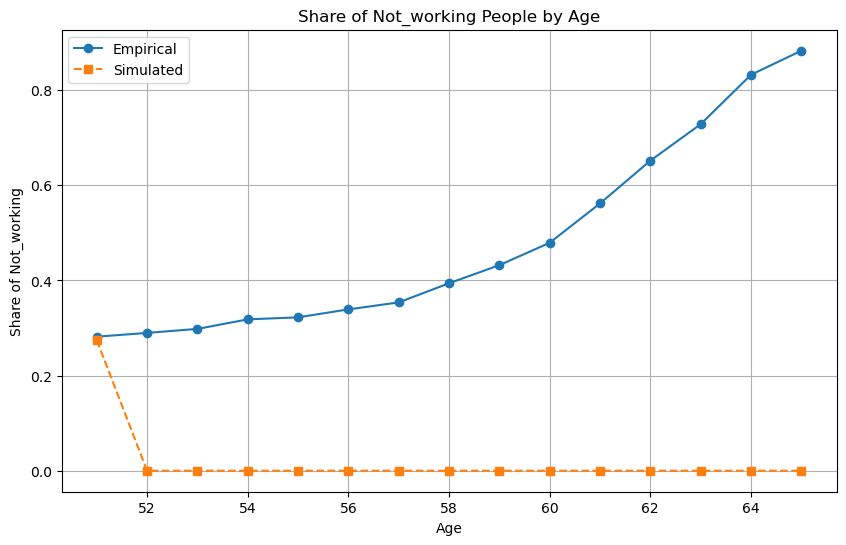

In [32]:
plot_working_status(empirical_moments, simulated_moments, 'not_working')

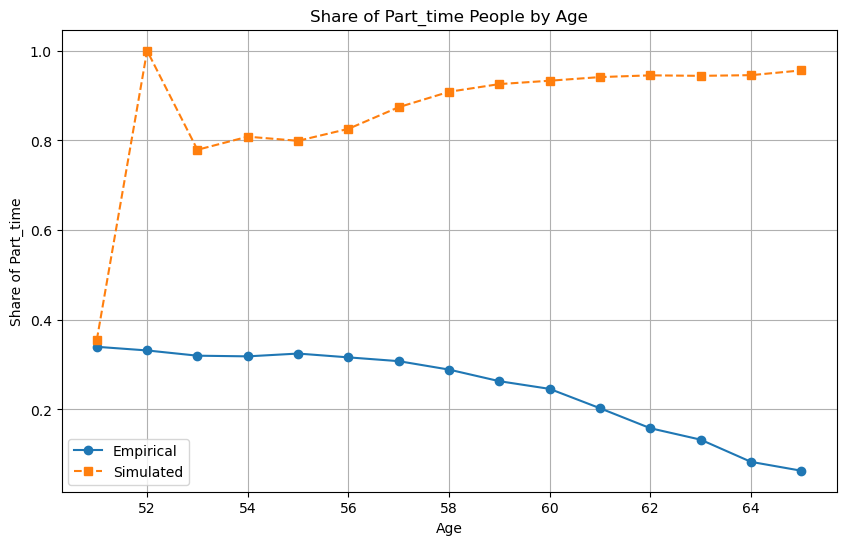

In [33]:
plot_working_status(empirical_moments, simulated_moments, 'part_time')

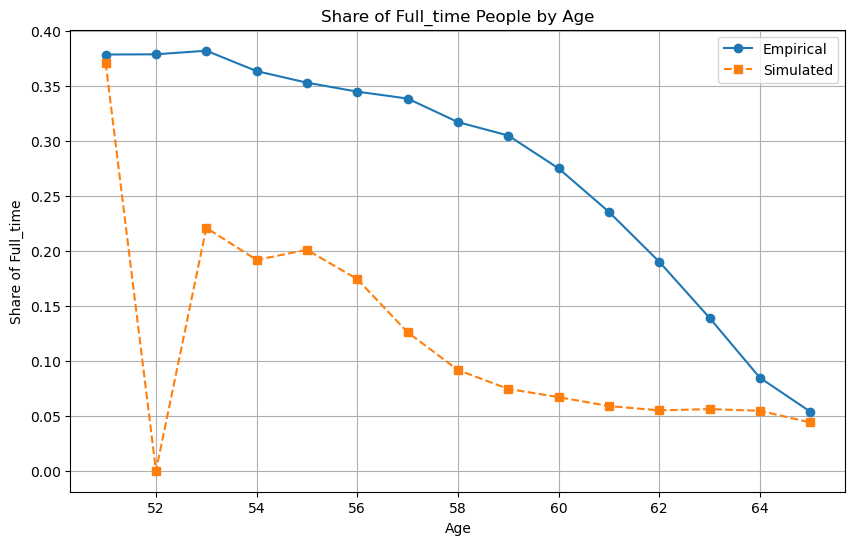

In [34]:
plot_working_status(empirical_moments, simulated_moments, 'full_time')

In [30]:
sim_arr

array([0.2744    , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.3547    , 1.        , 0.7791    , 0.8083    , 0.7991    ,
       0.8258    , 0.8741    , 0.9084    , 0.9256    , 0.9331    ,
       0.9412    , 0.9451    , 0.944     , 0.9455    , 0.9561    ,
       0.3709    , 0.        , 0.2209    , 0.1917    , 0.2009    ,
       0.1742    , 0.1259    , 0.0916    , 0.0744    , 0.0669    ,
       0.0588    , 0.0549    , 0.056     , 0.0545    , 0.0439    ,
       0.15166   , 0.11896   , 0.06044   , 0.01512888, 0.95311373,
       0.03175741, 0.        , 0.1575302 , 0.8424698 , 0.        ,
       1.        , 0.        , 0.        , 0.92796564, 0.07203436,
       0.        , 0.7583796 , 0.24162044, 0.9244493 , 0.07555065,
       0.73573154, 0.26426846, 0.59156996, 0.40843004, 0.6409128 ,
       0.35908726, 0.9006334 , 0.09936661, 0.9173928 , 0.08260

In [49]:
# Extract ages and corresponding shares
ages = [int(idx.split('_')[-1]) for idx in data.index if idx.startswith('not_working_age_')]
shares = data.loc[data.index.str.startswith('not_working_age_')].values.ravel()

In [50]:
ages

[51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]

In [51]:
shares

array([0.2817563, 0.2896943, 0.2981287, 0.3181575, 0.3224364, 0.3390837,
       0.3538098, 0.3940612, 0.4321149, 0.4791804, 0.5618399, 0.6517516,
       0.7283603, 0.8322718, 0.8828348])

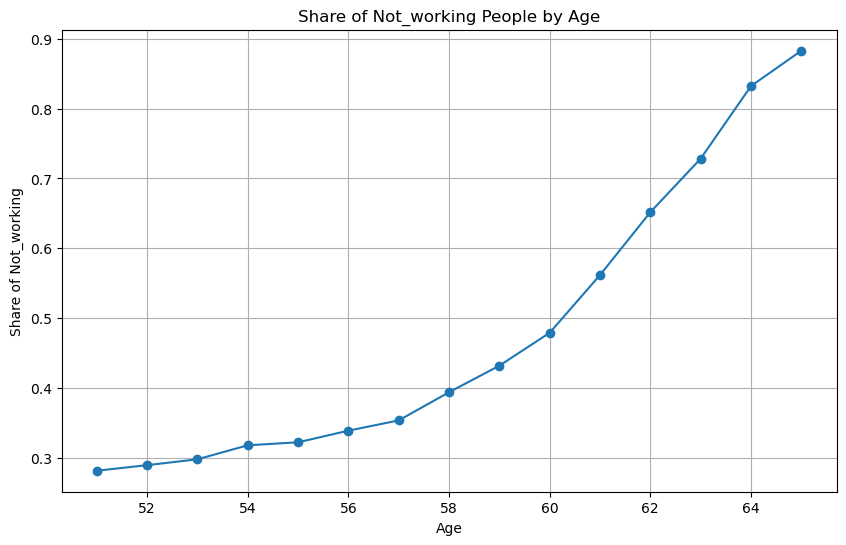

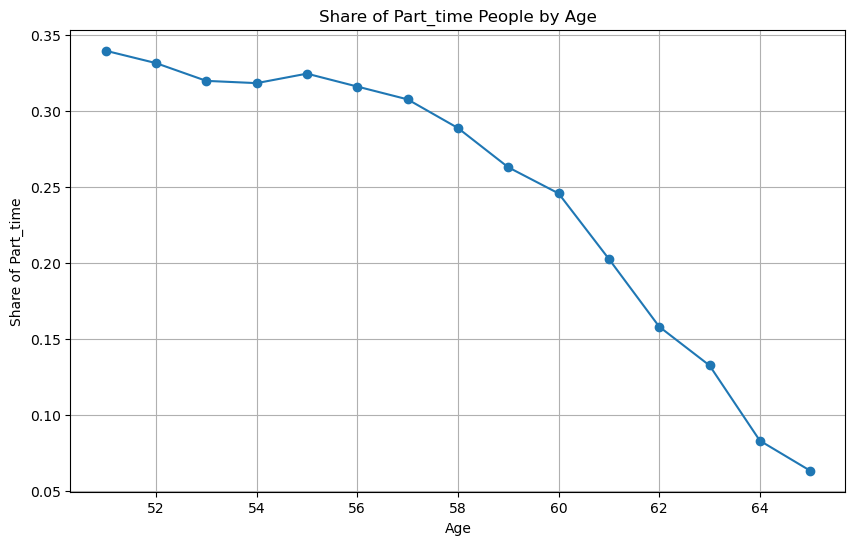

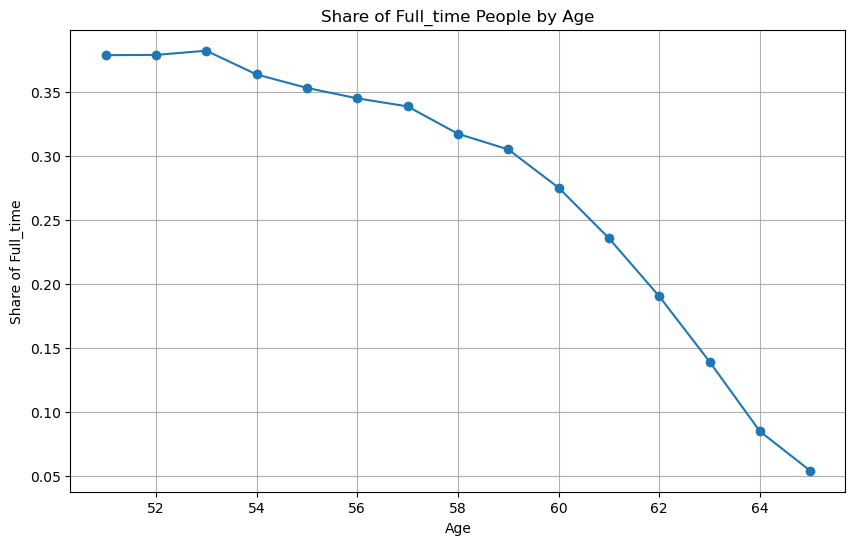

In [53]:
plot_working_status(data, 'not_working')
plot_working_status(data, 'part_time')
plot_working_status(data, 'full_time')